In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [3]:
warnings.filterwarnings("ignore")

In [4]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)
        plt.xticks(rotation=45)

    plt.show()
    
    
def plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half):
    plt.figure(figsize=(10, 6))
    plt.scatter(column.index, column, label='Original Values')
    plt.plot(column.index, linear_a * column.index + linear_b, color='red', label='Linear Regression')
    plt.plot(column.index, linear_a_half * column.index + linear_b_half, color='green', label='Recent Linear Regression')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Original Values vs. Linear Regression vs. Recent Linear Regression')
    plt.grid(True)
    plt.show()

In [5]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [6]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column

def extract_valid_values(column):
    valid_values = []
    valid_indexes = []
    for index, value in enumerate(column):
        if not pd.isnull(value) and not np.isnan(value):
            valid_values.append(value)
            valid_indexes.append(index)
    extracted_column = pd.Series(
        valid_values,
        index=valid_indexes
    )
    return extracted_column

def linear_regression_first_four_filler(column):
    size = len(column) - 1
    processed_column = extract_valid_values(column)
    mean_valid_values_quarter = processed_column.mean()/4
    mean_valid_values_quarter_upper = processed_column.mean() + mean_valid_values_quarter
    
    model = sm.OLS(processed_column, sm.add_constant(processed_column.index))
    result = model.fit()
    linear_a = result.params[1]
    linear_b = result.params['const']
    half_column = processed_column[:(len(processed_column) // 2)]
    model2 = sm.OLS(half_column, sm.add_constant(half_column.index))
    result2 = model2.fit()
    linear_a_half = result2.params[1]
    linear_b_half = result2.params['const']
    
    for i in range(0,4):
        if pd.isnull(column.at[i]) or np.isnan(column.at[i]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[i] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[i] = mean_valid_values_quarter_upper
            else:
                column.at[i] = projected
        x = size - 4 + i
        if pd.isnull(column.at[x]) or np.isnan(column.at[x]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[x] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[x] = mean_valid_values_quarter_upper
            else:
                column.at[x] = projected
    plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half)
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [15]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_columns = 0, skiped_rows = 0):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)

        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

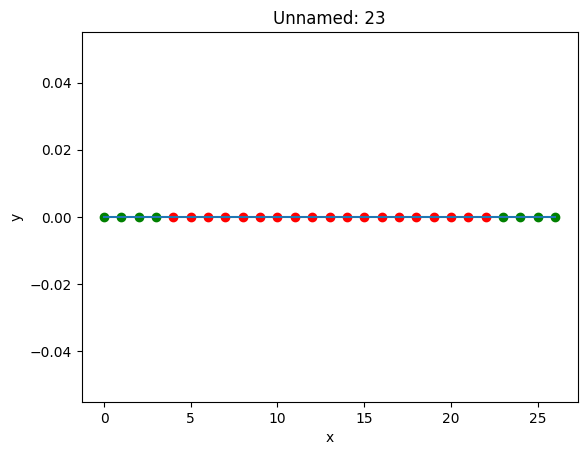

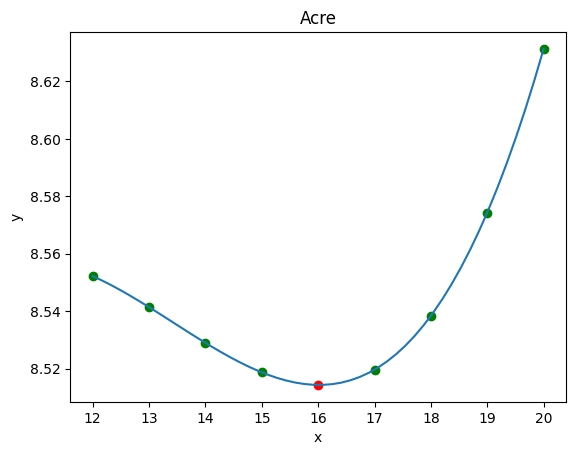

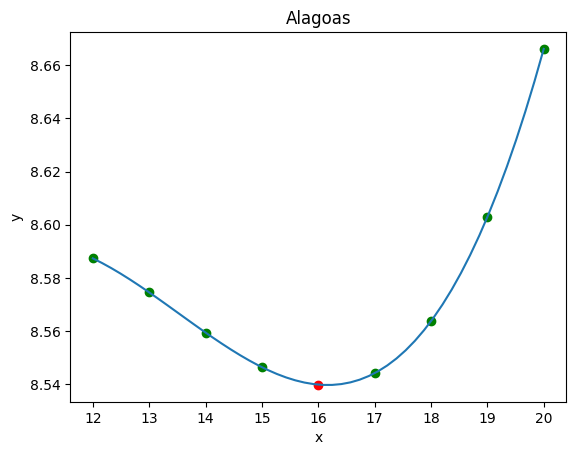

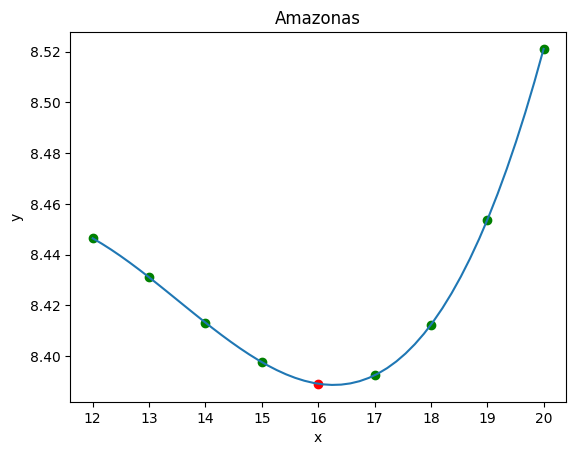

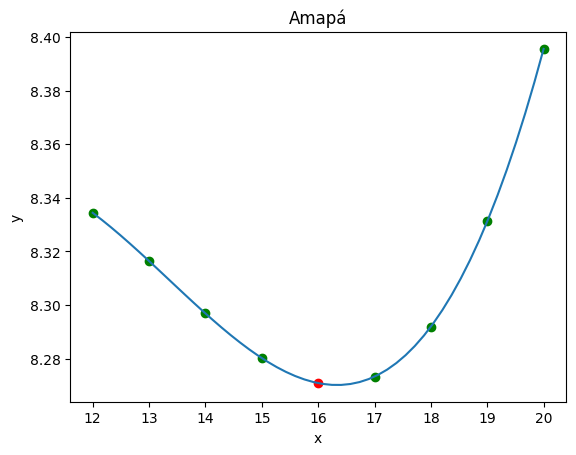

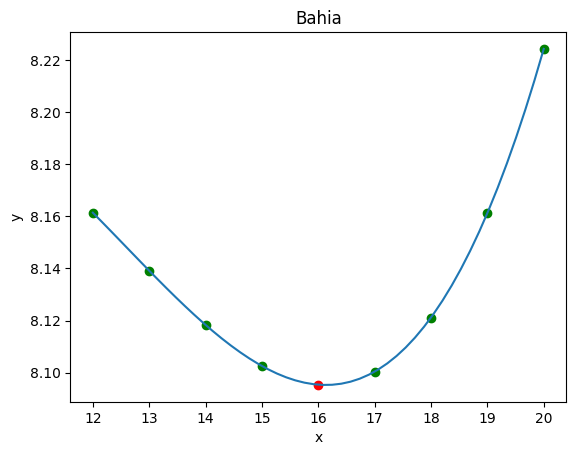

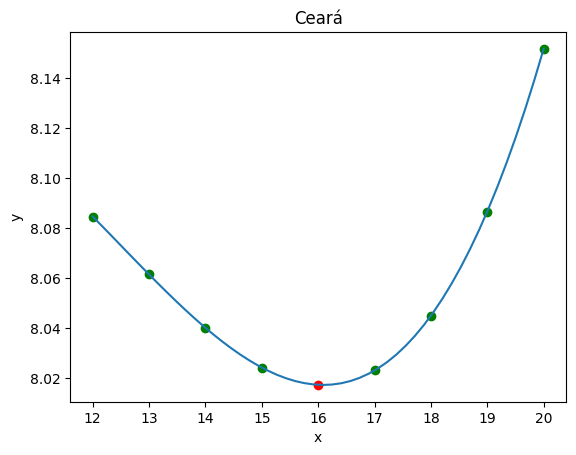

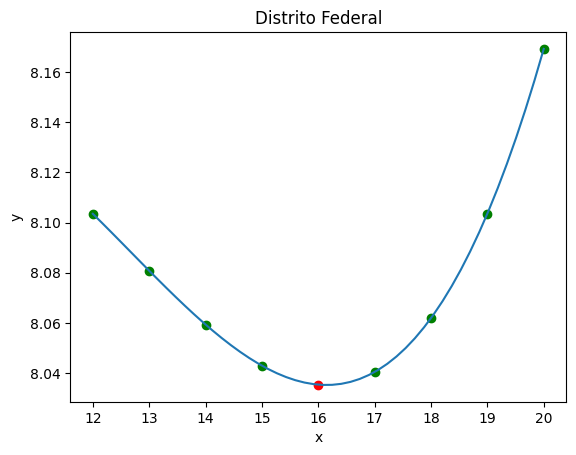

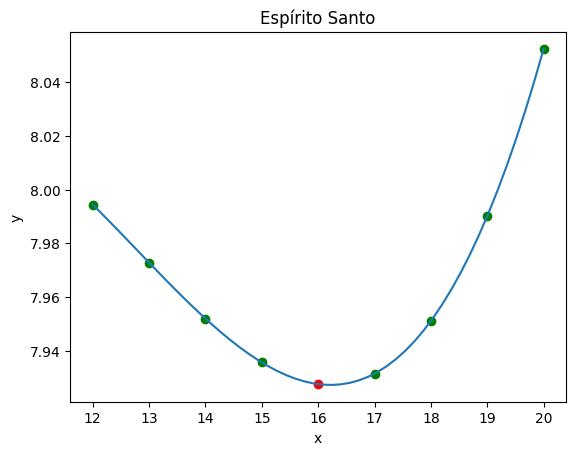

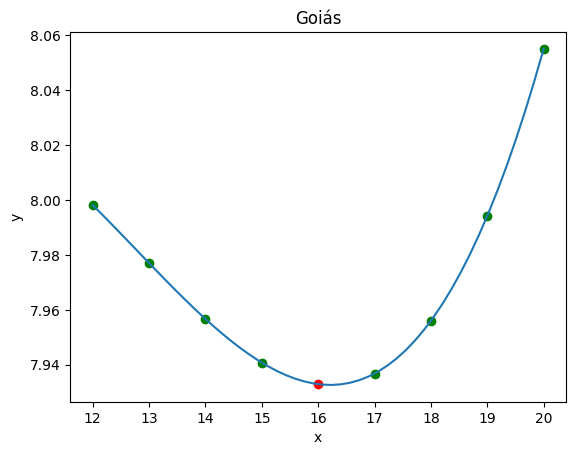

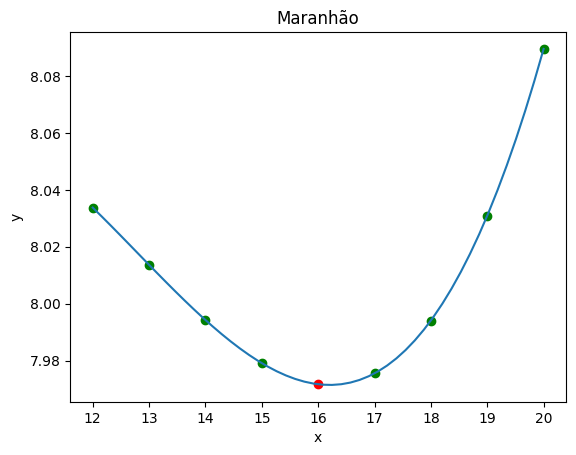

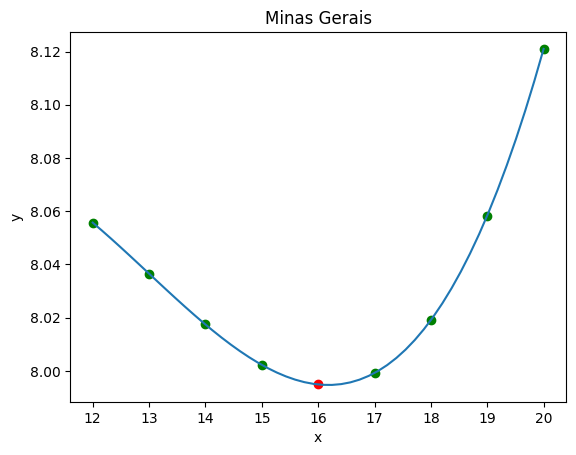

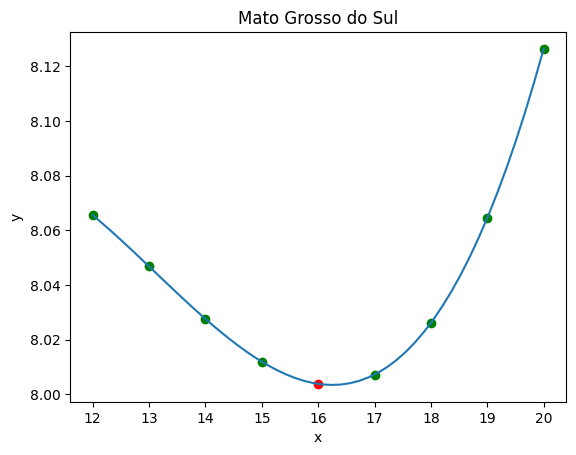

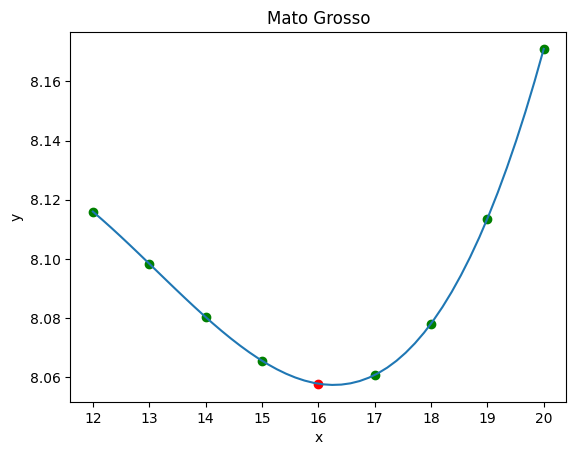

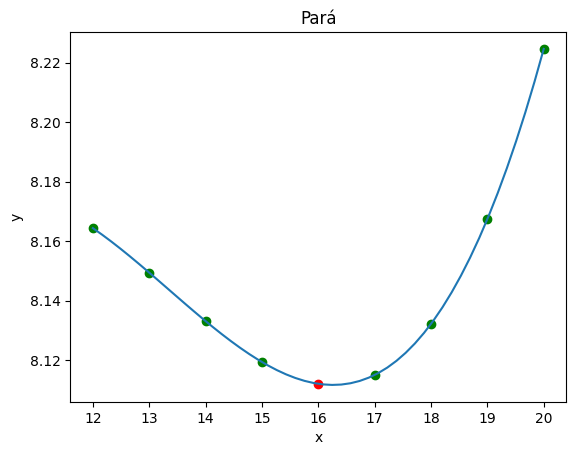

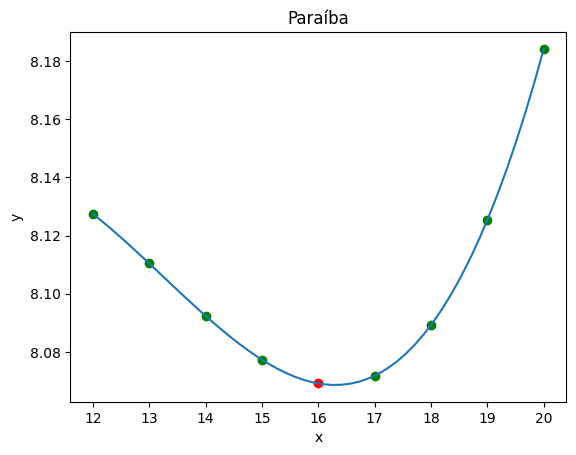

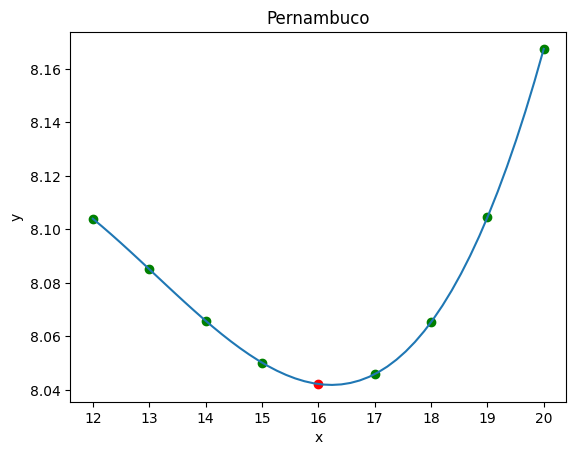

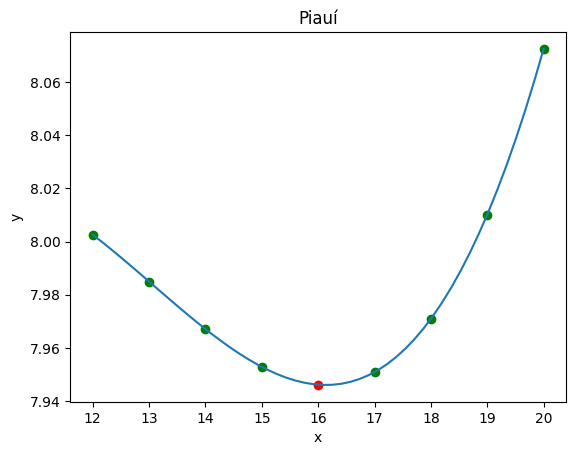

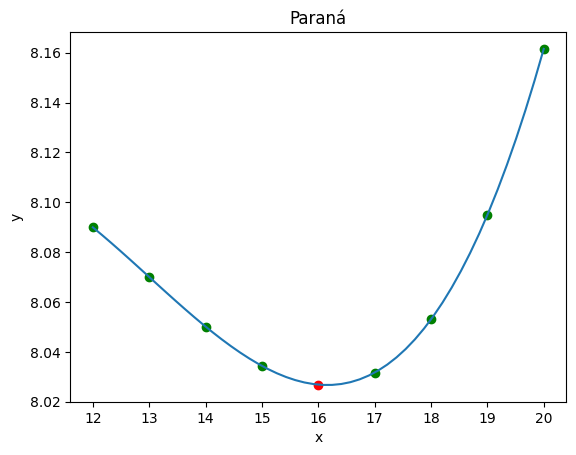

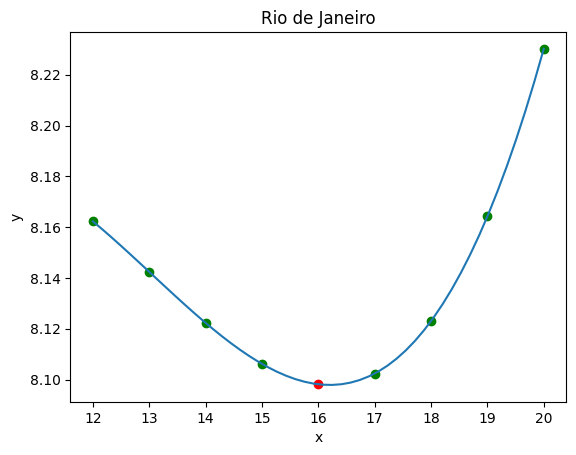

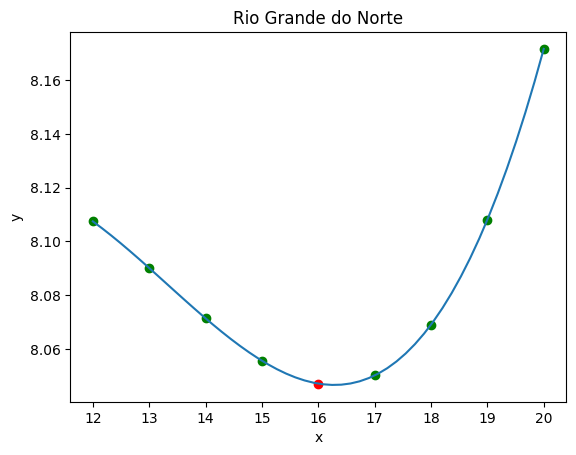

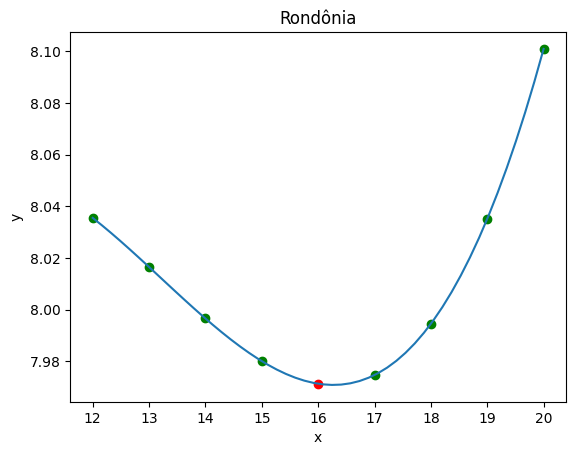

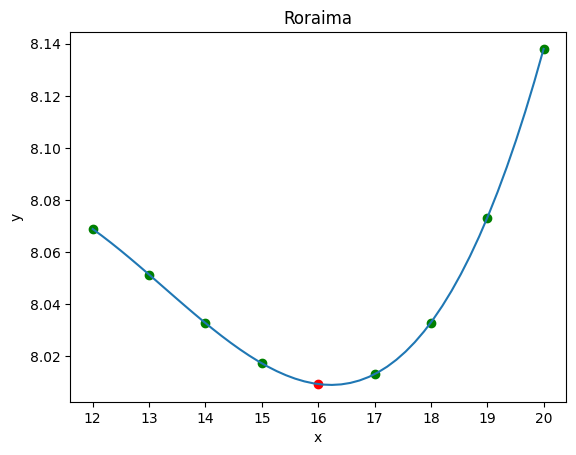

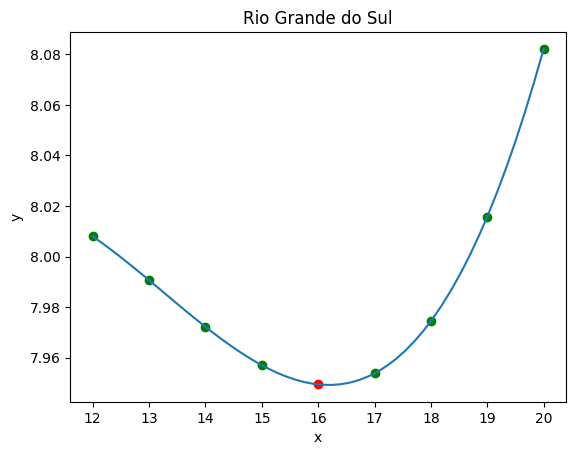

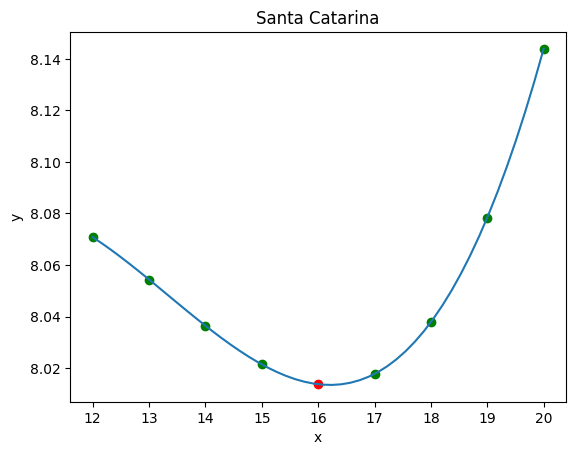

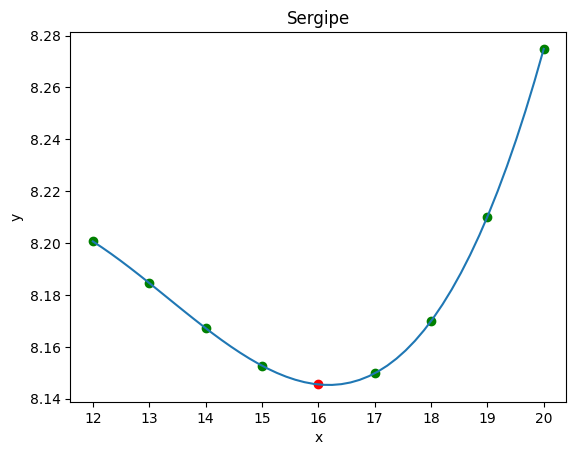

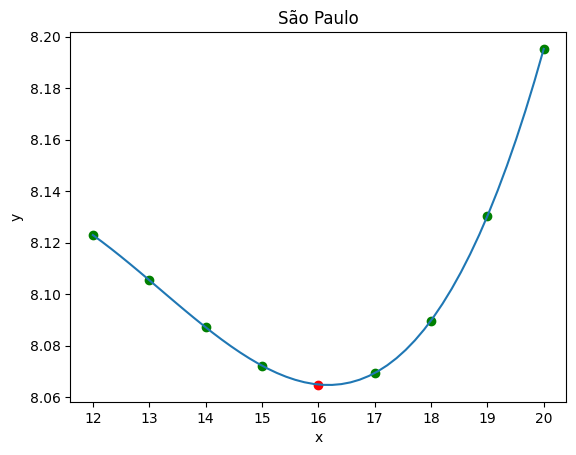

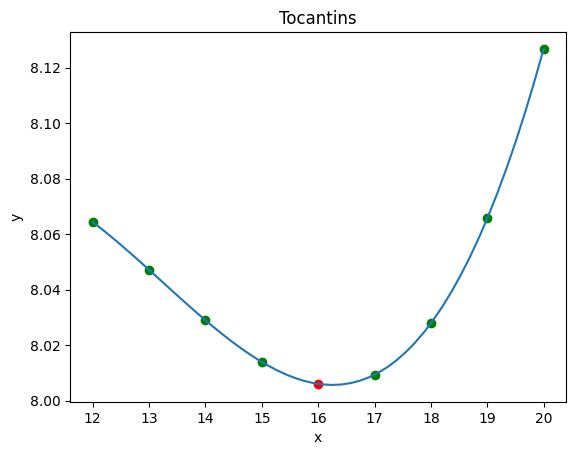

,Unnamed: 0,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
0,1992,8.543005,8.583810,8.452699,8.300891,8.142592,8.081261,8.107595,7.983952,7.987324,...,8.126130,8.181382,8.120008,8.070484,8.100281,8.049943,8.103397,8.226591,8.149897,8.068701
1,1993,8.621404,8.665029,8.532697,8.382008,8.214394,8.152784,8.178694,8.052075,8.056865,...,8.196317,8.253095,8.189427,8.140139,8.172823,8.120059,8.173420,8.298252,8.219312,8.138550
2,1995,8.695869,8.745963,8.617730,8.476544,8.303908,8.241545,8.266821,8.139536,8.144149,...,8.279495,8.336969,8.272775,8.223169,8.258914,8.202517,8.255547,8.380727,8.305065,8.223995
3,1996,8.774194,8.830215,8.696890,8.556566,8.386763,8.322788,8.347696,8.216981,8.218907,...,8.339728,8.398759,8.332116,8.280462,8.319073,8.272212,8.326273,8.451789,8.373971,8.291305
4,1997,8.833269,8.890903,8.754599,8.613320,8.435225,8.370102,8.393696,8.266598,8.267768,...,8.384611,8.444118,8.376183,8.320180,8.357277,8.318330,8.374170,8.500556,8.422576,8.339509
5,1998,8.878243,8.935548,8.791128,8.655948,8.474821,8.407780,8.431611,8.303010,8.303117,...,8.419437,8.481480,8.413319,8.359062,8.396177,8.348109,8.407246,8.534915,8.452292,8.370870
6,1999,8.869476,8.921520,8.780503,8.656116,8.469426,8.399314,8.421893,8.293592,8.291616,...,8.403089,8.467648,8.400136,8.342115,8.377094,8.324275,8.386016,8.517770,8.436234,8.359602
7,2001,8.801259,8.854527,8.722516,8.609291,8.423796,8.351179,8.371172,8.247182,8.244328,...,8.349729,8.418383,8.351254,8.291979,8.328856,8.269982,8.333020,8.468914,8.386072,8.314213
8,2002,8.748562,8.798929,8.669781,8.552575,8.375053,8.301037,8.319491,8.199103,8.197745,...,8.302594,8.373170,8.308495,8.245993,8.284366,8.221885,8.285104,8.418909,8.338964,8.269036
9,2003,8.722906,8.765721,8.630942,8.514392,8.348779,8.274459,8.293882,8.177444,8.179785,...,8.284196,8.356512,8.294170,8.226062,8.263084,8.192273,8.256606,8.389943,8.310335,8.243830


In [37]:
df_2014 = read_csv_replace_missing_by_polynomial('desemprego_ipeadata.csv', 2, 1)
df_2014 = df_2014.iloc[:, 2:-1]
df_2014 = df_2014.T
header = df_2014.iloc[0]
df_2014 = df_2014[1:]
df_2014.columns = header
df_2014 = df_2014.rename_axis('Ano')
row_2010 = pd.DataFrame({col: [np.nan] for col in df_2014.columns})
row_2010.index = ['2010']
df_2014 = pd.concat([df_2014, row_2010])
df_2014.sort_index(inplace=True)
df_2014.to_csv("2014_middle_desemprego.csv")
df_2014 = read_csv_replace_missing_by_polynomial('2014_middle_desemprego.csv', 0, 0)
df_2014

In [38]:
df = pd.read_csv('desemprego_pos_2012.csv')

df_transposed = df.transpose()
df_transposed
new_header = df_transposed.iloc[0]
df_transposed = df_transposed[1:]
df_transposed.columns = new_header
df_transposed = df_transposed.rename_axis('Ano')
df_transposed

Estado,Acre,Rondônia,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,...,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
Ano,,,,,,,,,,,,,,,,,,,,,
2012,9.2,8.1,11.1,8.5,8.0,12.6,8.4,7.9,7.7,7.3,...,7.6,8.6,7.8,5.6,4.1,5.3,7.6,6.6,6.3,8.8
2012.1,9.0,6.3,9.1,5.9,7.9,14.7,7.8,9.2,7.1,8.2,...,7.3,7.5,7.5,5.3,3.8,5.1,7.1,5.8,5.3,8.5
2012.2,7.8,5.9,9.5,7.5,7.2,14.2,7.3,7.7,6.2,8.1,...,6.9,7.5,7.0,4.7,3.2,4.7,5.0,5.2,5.0,8.7
2012.3,8.2,5.2,8.3,8.4,6.9,12.1,7.7,7.6,7.0,7.6,...,6.7,6.9,6.8,4.5,2.7,4.4,5.0,4.8,5.1,8.9
2013,10.9,6.2,10.4,8.9,7.9,11.5,9.3,9.5,8.4,8.9,...,7.8,7.3,7.8,4.9,3.7,5.4,4.8,5.8,6.8,9.7
2013.1,9.6,4.9,10.3,8.6,7.7,14.5,8.3,9.4,7.5,8.5,...,7.7,7.0,7.5,4.6,3.5,4.6,5.0,4.5,5.8,9.2
2013.2,8.9,4.6,8.4,8.0,7.8,11.0,6.2,7.5,7.5,7.3,...,7.2,6.9,7.4,4.3,2.8,4.9,4.4,3.9,5.2,9.0
2013.3,7.0,5.0,7.7,6.8,6.1,9.2,6.5,5.6,7.0,6.9,...,5.9,6.2,6.6,3.8,2.6,4.7,4.5,3.8,3.9,8.5
2014,8.1,5.0,8.3,7.7,7.8,11.4,8.6,6.4,7.1,7.9,...,6.4,6.8,7.3,4.2,3.1,5.4,4.7,4.5,5.7,9.1


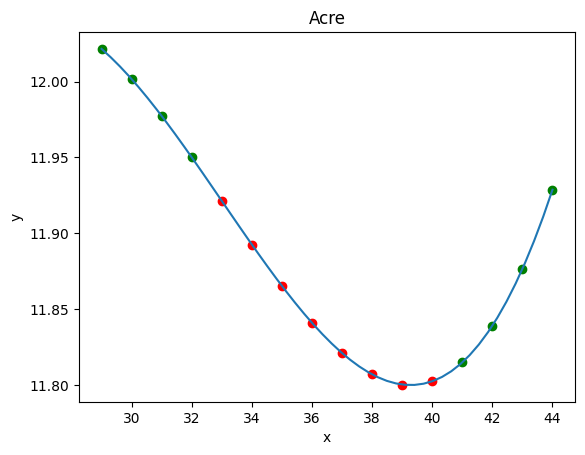

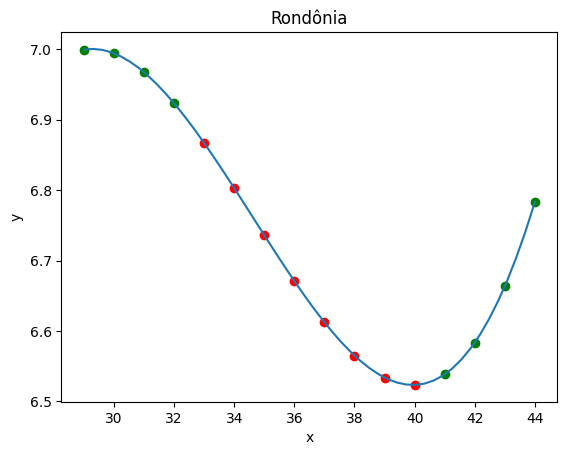

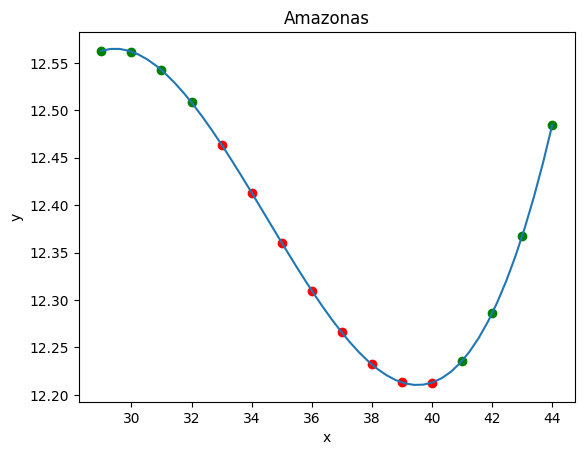

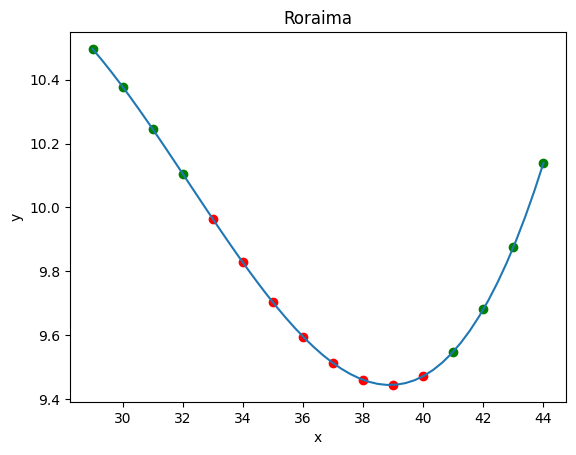

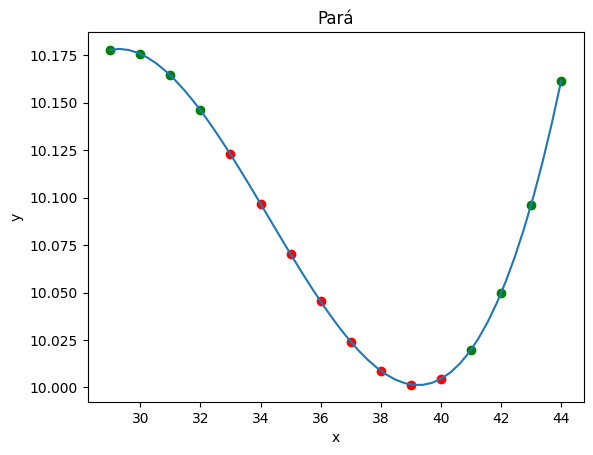

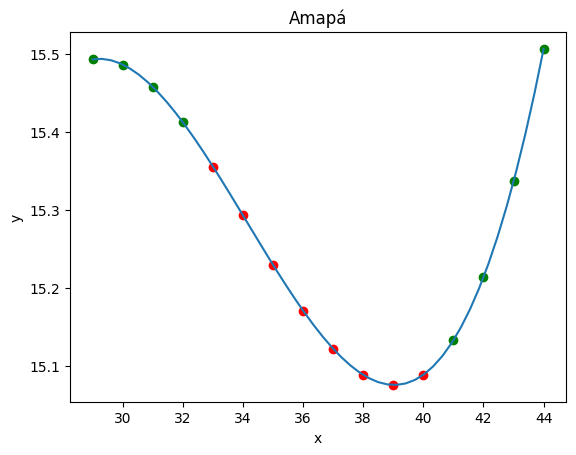

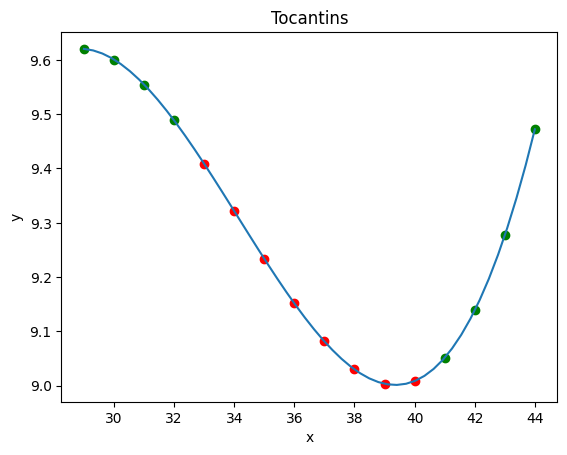

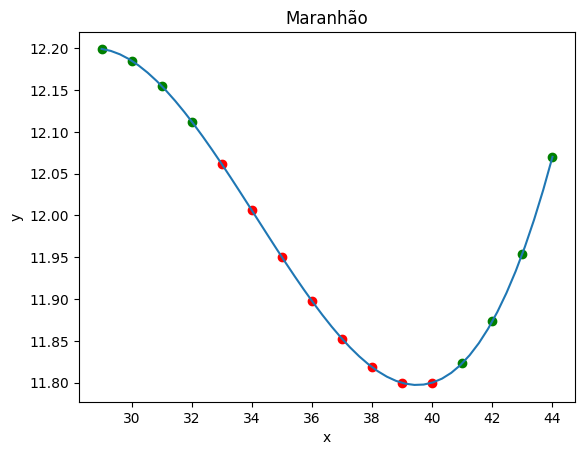

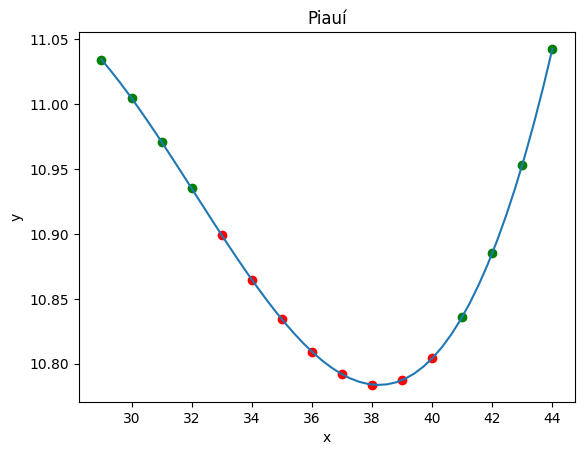

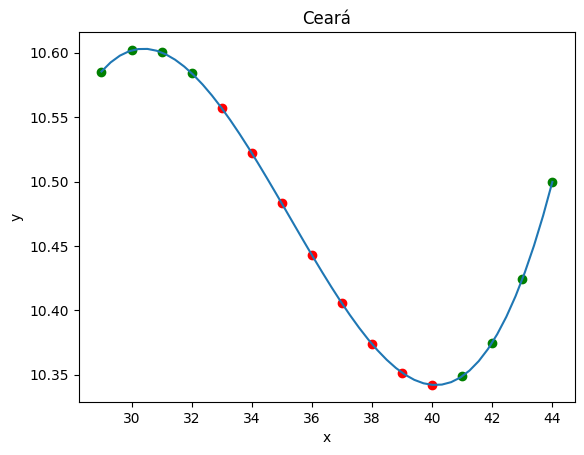

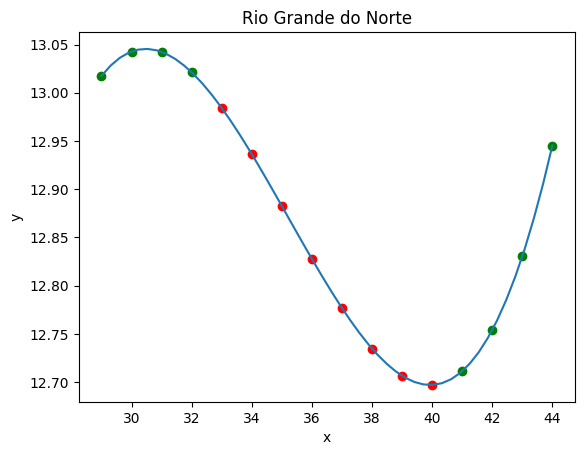

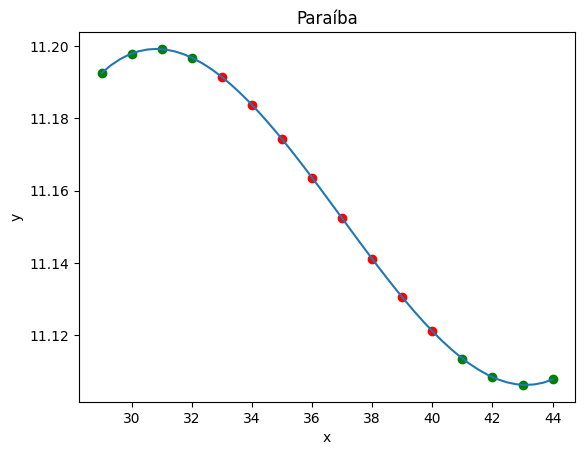

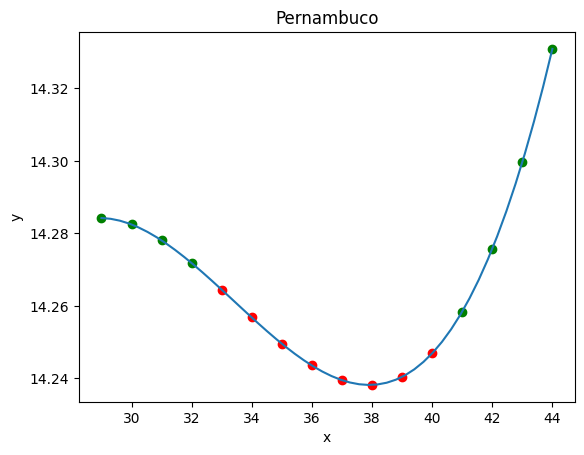

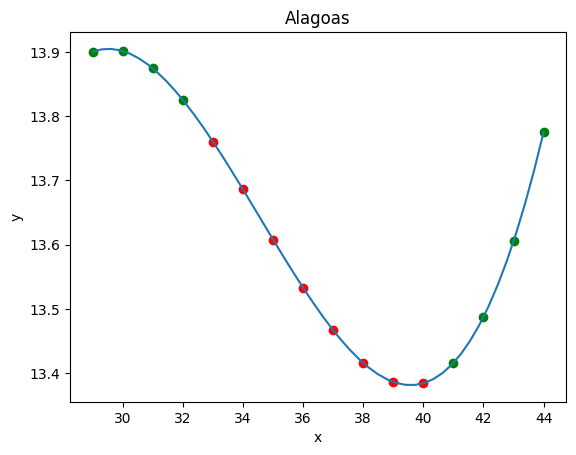

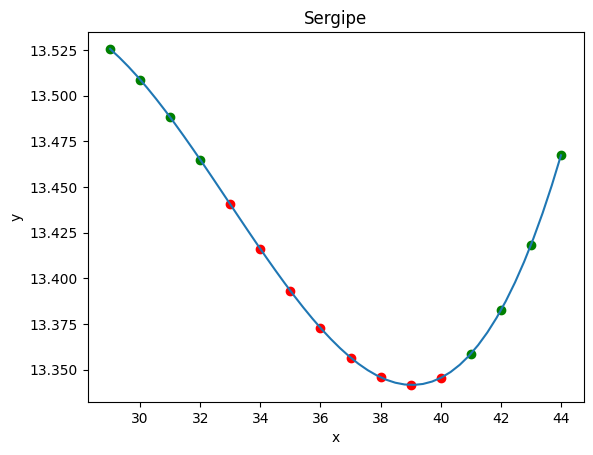

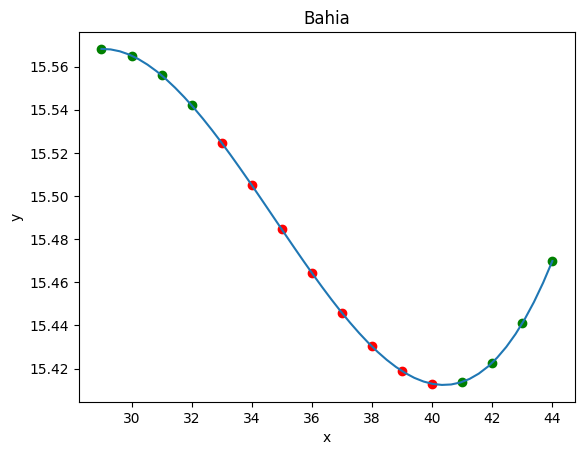

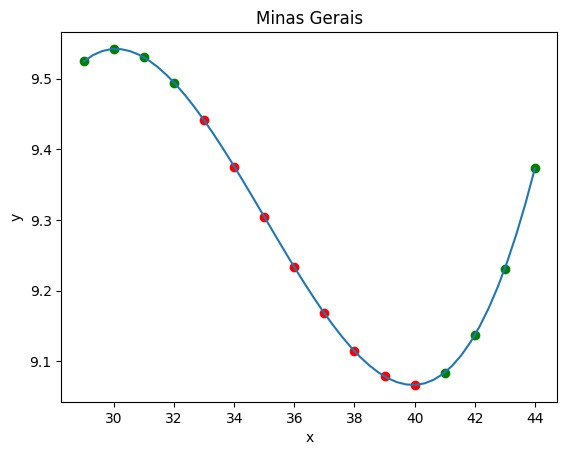

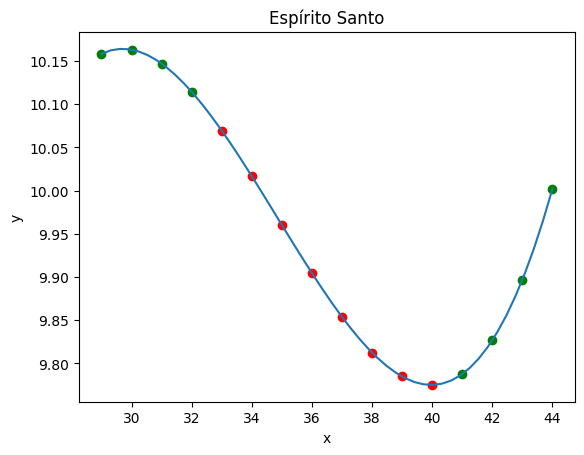

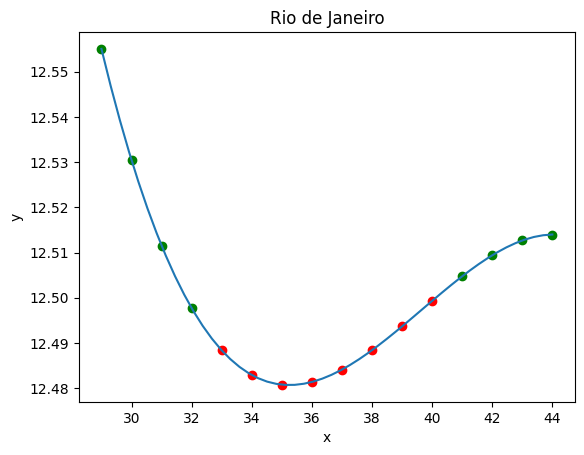

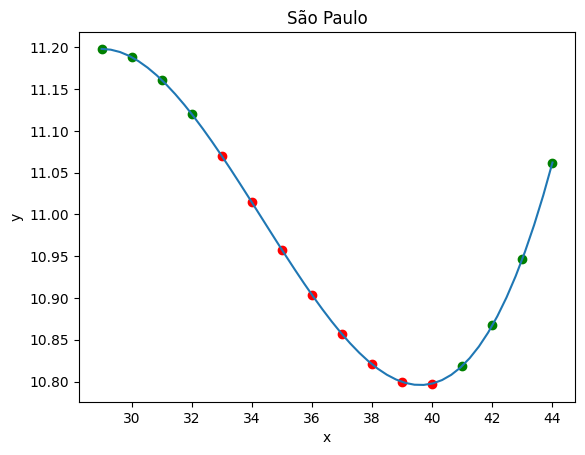

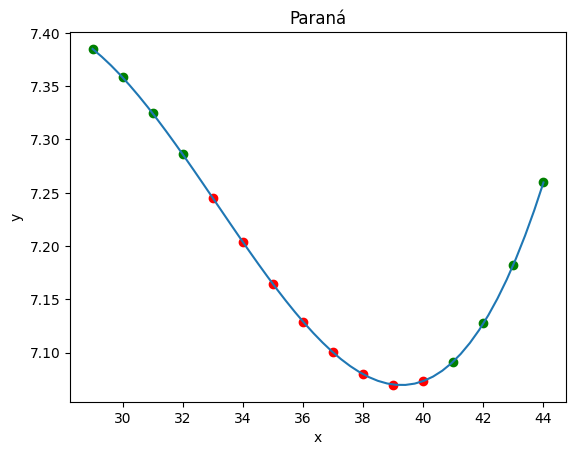

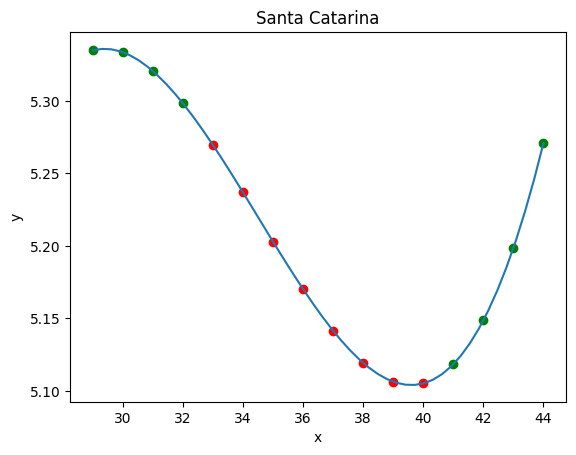

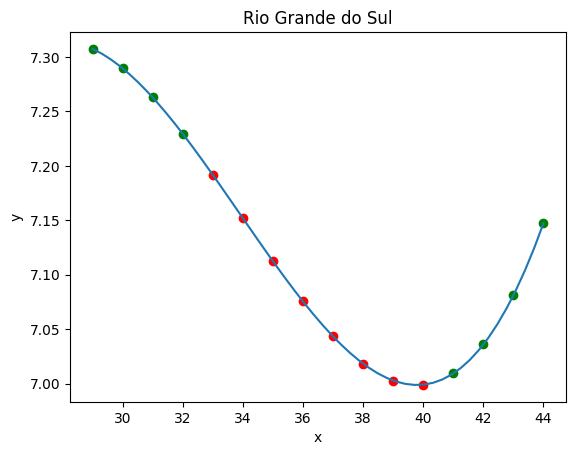

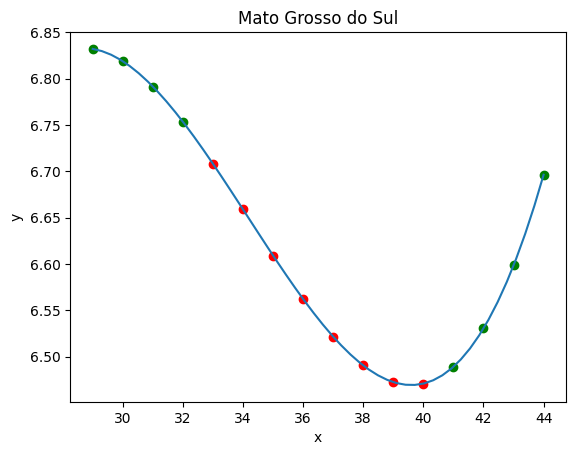

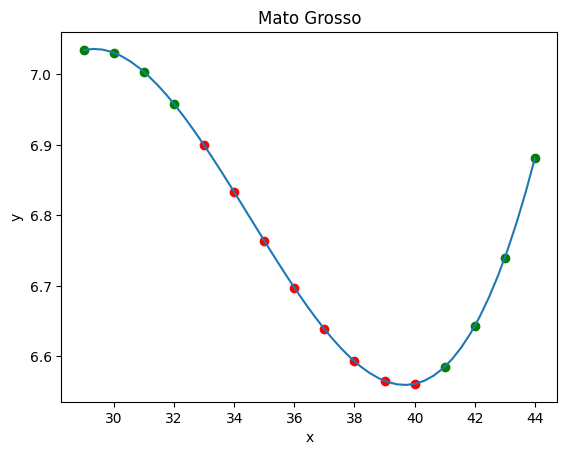

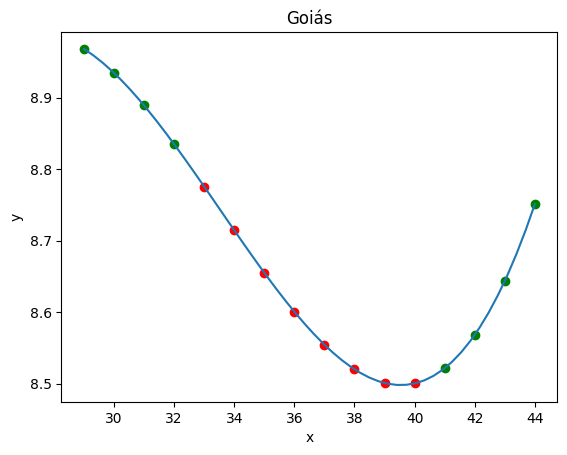

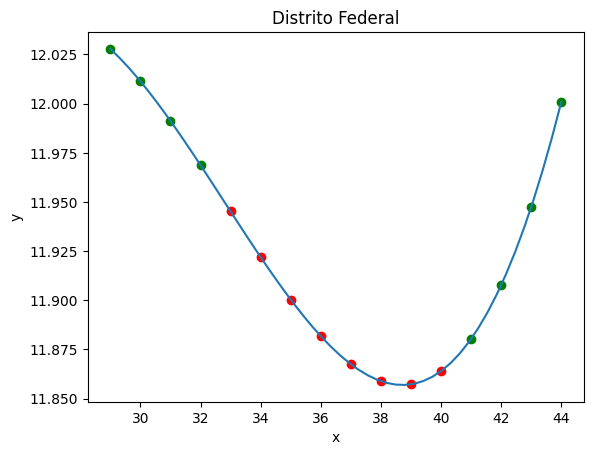

,Ano,Acre,Rondônia,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,...,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
0,2012.0,10.076000,6.464000,11.108000,8.360000,9.188000,13.740000,9.232000,9.964000,8.776000,...,9.156000,9.492000,9.728000,6.280000,4.616000,6.440000,6.336000,6.604000,7.596000,10.556000
1,2012.1,10.249077,6.471692,11.231077,8.479231,9.314923,14.086154,9.347385,10.217846,8.999077,...,9.332923,9.757385,9.958769,6.414615,4.712154,6.559231,6.339846,6.680923,7.719077,10.690615
2,2012.2,10.408336,6.567989,11.382929,8.764416,9.429738,14.223191,9.425162,10.395624,9.199077,...,9.484775,10.024051,10.173584,6.540541,4.801043,6.677749,6.347254,6.717960,7.856114,10.842467
3,2012.3,10.604765,6.682274,11.565072,9.003702,9.540452,14.423191,9.539448,10.631338,9.420505,...,9.609775,10.291908,10.373584,6.654827,4.911757,6.777749,6.418682,6.778674,7.973971,10.963896
4,2013.0,10.953041,6.816757,11.830589,9.238184,9.702521,14.705950,9.704965,10.938235,9.627402,...,9.802878,10.585012,10.608067,6.809999,5.070378,6.901887,6.573855,6.930399,8.170523,11.146654
5,2013.1,11.049707,6.840090,11.950589,9.444851,9.815854,14.892616,9.778299,11.114901,9.780735,...,9.909545,10.851679,10.778067,6.949999,5.150378,6.998554,6.693855,7.013732,8.297189,11.283321
6,2013.2,11.165836,6.949768,12.053815,9.651303,9.931984,14.970036,9.855718,11.276192,9.954929,...,10.006319,11.096840,10.926454,7.095161,5.224571,7.137264,6.780951,7.126635,8.461706,11.412353
7,2013.3,11.322086,7.062268,12.200690,9.870053,9.978859,15.120036,9.952593,11.429317,10.136179,...,10.106319,11.312465,11.057704,7.192036,5.305821,7.212264,6.852826,7.204760,8.630456,11.524853
8,2014.0,11.525117,7.168328,12.409781,10.170053,10.121283,15.365490,10.104108,11.753559,10.351330,...,10.269956,11.570041,11.230431,7.319308,5.399761,7.327415,6.955857,7.350215,8.860759,11.679399
9,2014.1,11.628908,7.234035,12.534319,10.244903,10.191625,15.485656,10.149687,11.915788,10.449856,...,10.387227,11.714587,11.349535,7.413833,5.469450,7.385822,7.024216,7.436585,8.956539,11.757562


In [39]:
df = read_csv_replace_missing_by_polynomial('desemprego_proc_pos_2012.csv', 0, 0)
df

In [43]:
df_ano = df.copy()
df_ano = df_ano.set_index('Ano')

df_ano.index = df_ano.index.astype(str).str.split('.').str[0]
df_avg = df_ano.groupby(['Ano']).mean()
df_avg

,Acre,Rondônia,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,...,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
Ano,,,,,,,,,,,,,,,,,,,,,
2012,10.334544,6.546489,11.321769,8.651837,9.368278,14.118134,9.385999,10.302202,9.098665,9.818854,...,9.395868,9.891336,10.058484,6.472496,4.760238,6.613682,6.360445,6.695389,7.786290,10.763245
2013,11.122668,6.917221,12.008921,9.551098,9.857304,14.922159,9.822894,11.189661,9.874811,10.221864,...,9.956265,10.961499,10.842573,7.011799,5.187787,7.062492,6.725372,7.068881,8.389968,11.341796
2014,11.666939,7.287260,12.610217,10.328300,10.244256,15.577783,10.192991,11.986521,10.508945,10.652422,...,10.450155,11.800434,11.415800,7.462443,5.511795,7.423718,7.077333,7.495401,9.015756,11.799788
2015,12.139670,7.654493,13.139356,10.723767,10.537304,16.255907,10.501090,12.529442,10.965401,11.020421,...,10.942052,12.471375,11.865646,7.813261,5.792915,7.683986,7.357560,7.838256,9.398111,12.093705
2016,12.458072,7.643673,13.263561,10.764101,10.587975,16.439693,10.392740,12.762358,11.203809,11.073199,...,10.979229,12.865739,11.874466,7.840669,5.798844,7.674279,7.332914,7.730867,9.378450,12.238790
2017,12.245790,7.282097,12.821072,10.533542,10.306831,16.090418,9.894472,12.460135,11.173036,10.712887,...,10.448735,12.728617,11.486716,7.553100,5.526597,7.404242,7.012814,7.251143,8.980786,12.085632
2018,12.148886,7.152179,12.662274,10.642202,10.211085,15.812868,9.761228,12.318837,11.037275,10.581166,...,10.241458,12.577126,11.319293,7.440077,5.417481,7.324869,6.911971,7.109465,8.919908,12.018938
2019,12.045733,7.004255,12.576164,10.430272,10.177874,15.509234,9.617662,12.204421,11.015949,10.594941,...,10.168769,12.544345,11.198876,7.368470,5.342752,7.291978,6.834977,7.037991,8.947167,12.023662
2020,11.905311,6.830604,12.440277,9.898626,10.115271,15.329624,9.371493,12.039300,10.881622,10.540017,...,10.043678,12.488461,11.044481,7.229325,5.254689,7.174483,6.687177,6.871142,8.745410,11.936222


In [45]:
df_until_2012 = df_2014.copy()
df_until_2012 = df_until_2012.iloc[:-3]
df_until_2012.set_index('Unnamed: 0', inplace=True)
df_until_2012.index.name = 'Ano'
df_until_2012

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1992,8.543005,8.583810,8.452699,8.300891,8.142592,8.081261,8.107595,7.983952,7.987324,8.010615,...,8.126130,8.181382,8.120008,8.070484,8.100281,8.049943,8.103397,8.226591,8.149897,8.068701
1993,8.621404,8.665029,8.532697,8.382008,8.214394,8.152784,8.178694,8.052075,8.056865,8.081445,...,8.196317,8.253095,8.189427,8.140139,8.172823,8.120059,8.173420,8.298252,8.219312,8.138550
1995,8.695869,8.745963,8.617730,8.476544,8.303908,8.241545,8.266821,8.139536,8.144149,8.169053,...,8.279495,8.336969,8.272775,8.223169,8.258914,8.202517,8.255547,8.380727,8.305065,8.223995
1996,8.774194,8.830215,8.696890,8.556566,8.386763,8.322788,8.347696,8.216981,8.218907,8.245953,...,8.339728,8.398759,8.332116,8.280462,8.319073,8.272212,8.326273,8.451789,8.373971,8.291305
1997,8.833269,8.890903,8.754599,8.613320,8.435225,8.370102,8.393696,8.266598,8.267768,8.297747,...,8.384611,8.444118,8.376183,8.320180,8.357277,8.318330,8.374170,8.500556,8.422576,8.339509
1998,8.878243,8.935548,8.791128,8.655948,8.474821,8.407780,8.431611,8.303010,8.303117,8.334035,...,8.419437,8.481480,8.413319,8.359062,8.396177,8.348109,8.407246,8.534915,8.452292,8.370870
1999,8.869476,8.921520,8.780503,8.656116,8.469426,8.399314,8.421893,8.293592,8.291616,8.324205,...,8.403089,8.467648,8.400136,8.342115,8.377094,8.324275,8.386016,8.517770,8.436234,8.359602
2001,8.801259,8.854527,8.722516,8.609291,8.423796,8.351179,8.371172,8.247182,8.244328,8.279010,...,8.349729,8.418383,8.351254,8.291979,8.328856,8.269982,8.333020,8.468914,8.386072,8.314213
2002,8.748562,8.798929,8.669781,8.552575,8.375053,8.301037,8.319491,8.199103,8.197745,8.232925,...,8.302594,8.373170,8.308495,8.245993,8.284366,8.221885,8.285104,8.418909,8.338964,8.269036


In [46]:
df_appended = df_until_2012.append(df_avg)
df_appended.columns = df_appended.columns + " - Desemprego"
df_appended.to_csv('desemprego_processado.csv', index=True)
df_appended

,Acre - Desemprego,Alagoas - Desemprego,Amazonas - Desemprego,Amapá - Desemprego,Bahia - Desemprego,Ceará - Desemprego,Distrito Federal - Desemprego,Espírito Santo - Desemprego,Goiás - Desemprego,Maranhão - Desemprego,...,Paraná - Desemprego,Rio de Janeiro - Desemprego,Rio Grande do Norte - Desemprego,Rondônia - Desemprego,Roraima - Desemprego,Rio Grande do Sul - Desemprego,Santa Catarina - Desemprego,Sergipe - Desemprego,São Paulo - Desemprego,Tocantins - Desemprego
Ano,,,,,,,,,,,,,,,,,,,,,
1992,8.543005,8.583810,8.452699,8.300891,8.142592,8.081261,8.107595,7.983952,7.987324,8.010615,...,8.126130,8.181382,8.120008,8.070484,8.100281,8.049943,8.103397,8.226591,8.149897,8.068701
1993,8.621404,8.665029,8.532697,8.382008,8.214394,8.152784,8.178694,8.052075,8.056865,8.081445,...,8.196317,8.253095,8.189427,8.140139,8.172823,8.120059,8.173420,8.298252,8.219312,8.138550
1995,8.695869,8.745963,8.617730,8.476544,8.303908,8.241545,8.266821,8.139536,8.144149,8.169053,...,8.279495,8.336969,8.272775,8.223169,8.258914,8.202517,8.255547,8.380727,8.305065,8.223995
1996,8.774194,8.830215,8.696890,8.556566,8.386763,8.322788,8.347696,8.216981,8.218907,8.245953,...,8.339728,8.398759,8.332116,8.280462,8.319073,8.272212,8.326273,8.451789,8.373971,8.291305
1997,8.833269,8.890903,8.754599,8.613320,8.435225,8.370102,8.393696,8.266598,8.267768,8.297747,...,8.384611,8.444118,8.376183,8.320180,8.357277,8.318330,8.374170,8.500556,8.422576,8.339509
1998,8.878243,8.935548,8.791128,8.655948,8.474821,8.407780,8.431611,8.303010,8.303117,8.334035,...,8.419437,8.481480,8.413319,8.359062,8.396177,8.348109,8.407246,8.534915,8.452292,8.370870
1999,8.869476,8.921520,8.780503,8.656116,8.469426,8.399314,8.421893,8.293592,8.291616,8.324205,...,8.403089,8.467648,8.400136,8.342115,8.377094,8.324275,8.386016,8.517770,8.436234,8.359602
2001,8.801259,8.854527,8.722516,8.609291,8.423796,8.351179,8.371172,8.247182,8.244328,8.279010,...,8.349729,8.418383,8.351254,8.291979,8.328856,8.269982,8.333020,8.468914,8.386072,8.314213
2002,8.748562,8.798929,8.669781,8.552575,8.375053,8.301037,8.319491,8.199103,8.197745,8.232925,...,8.302594,8.373170,8.308495,8.245993,8.284366,8.221885,8.285104,8.418909,8.338964,8.269036


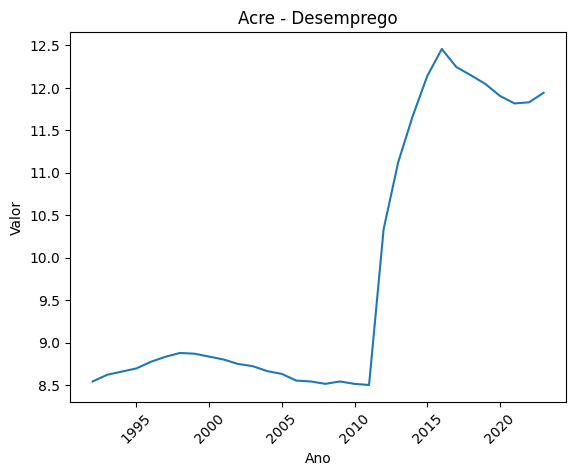

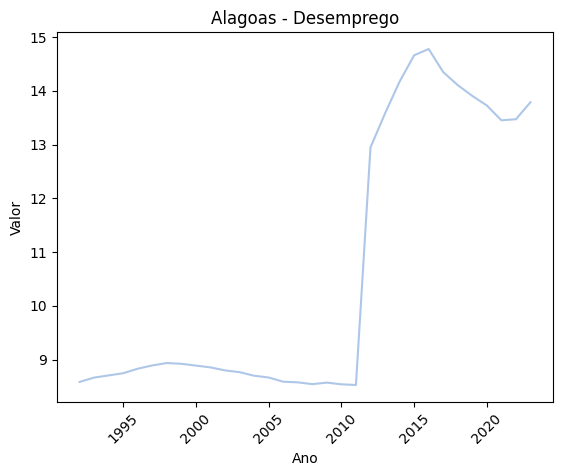

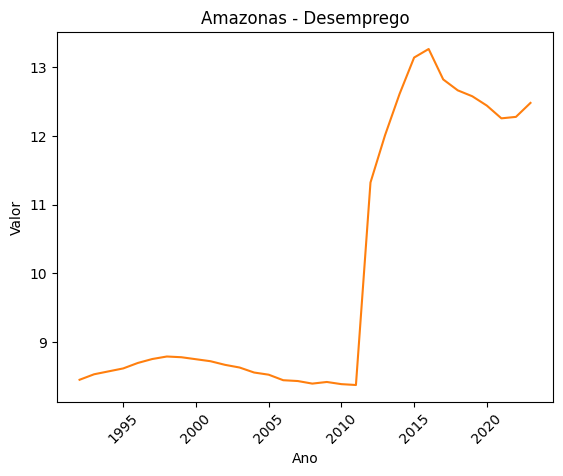

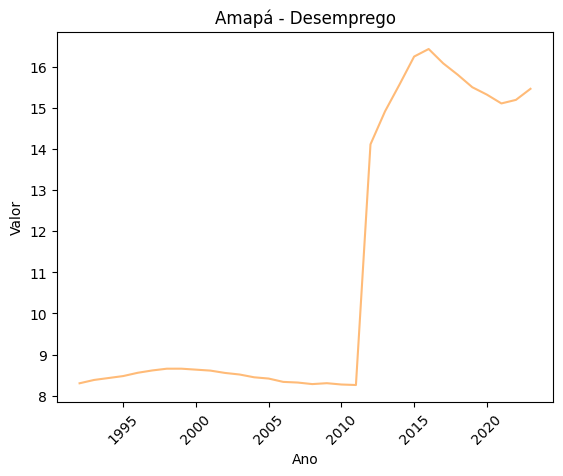

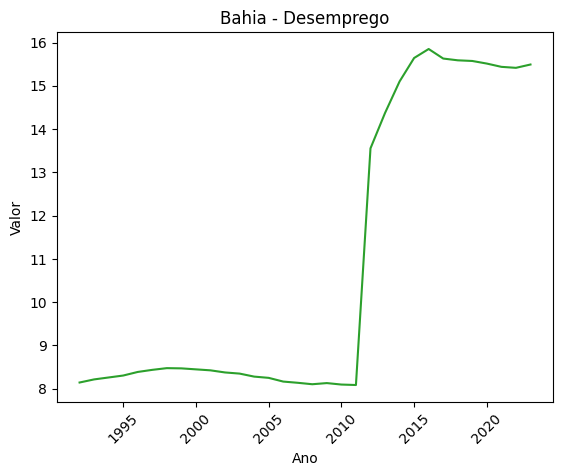

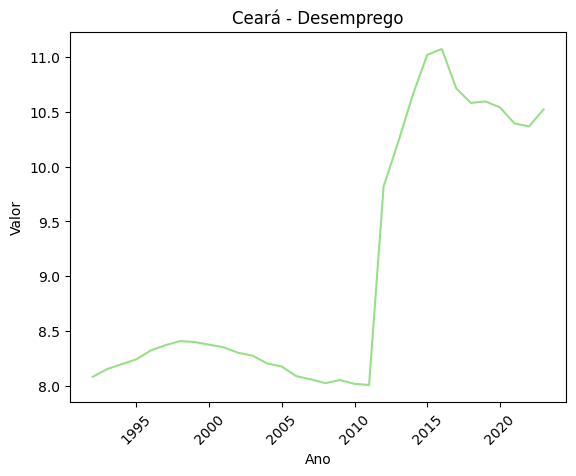

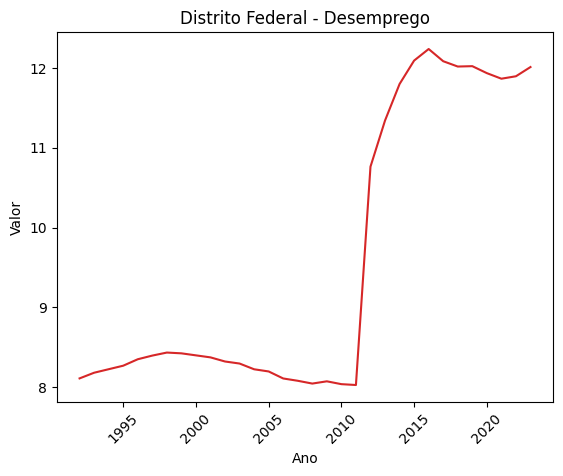

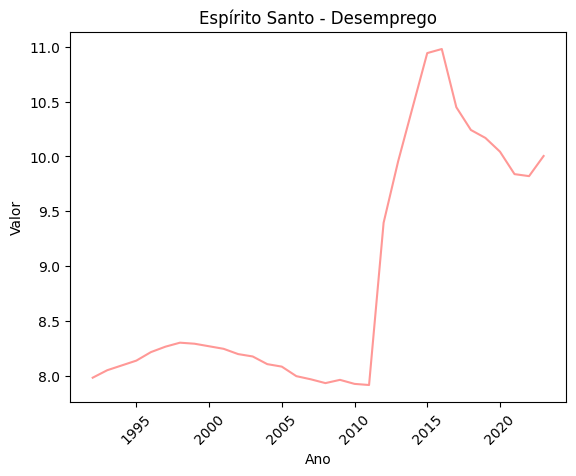

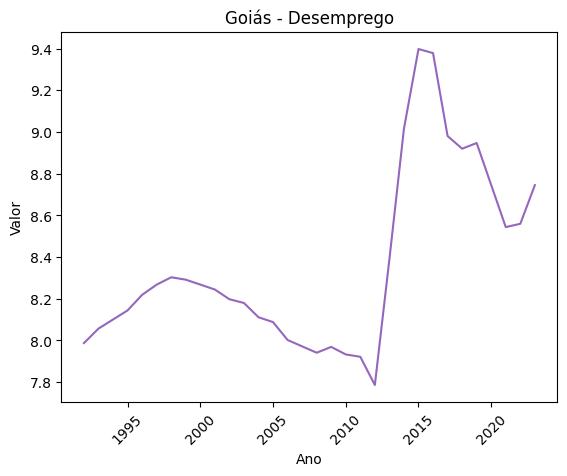

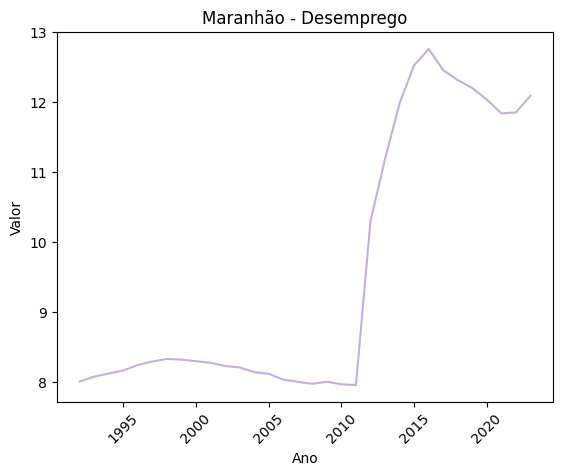

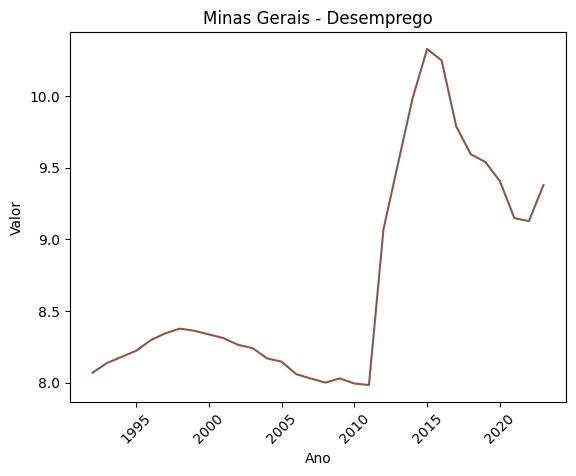

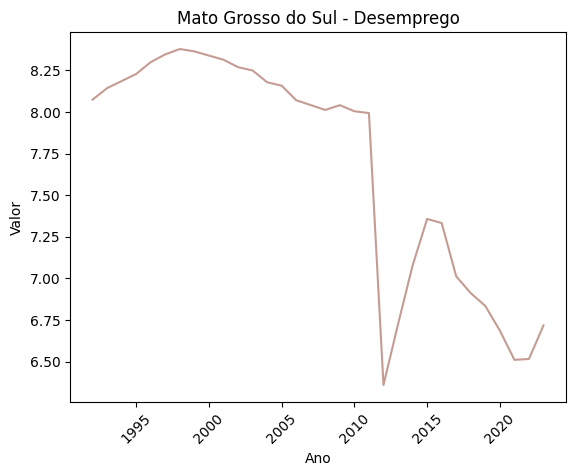

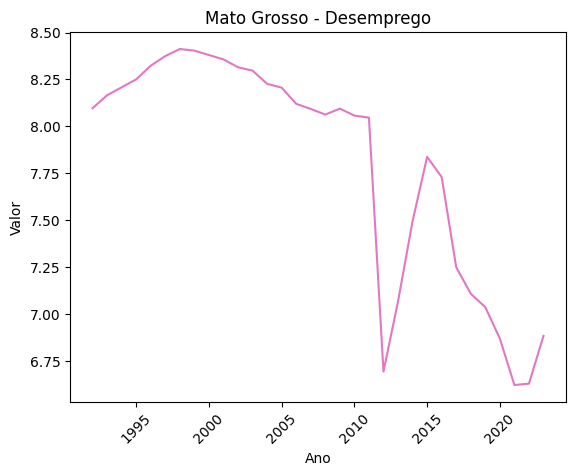

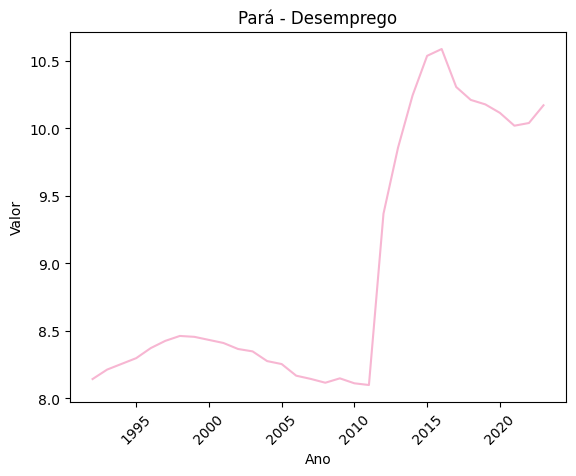

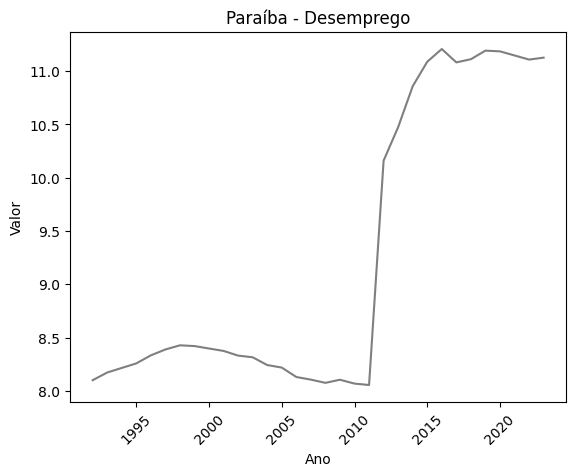

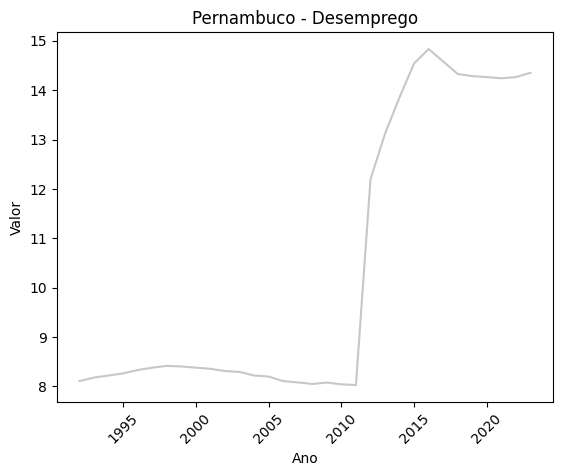

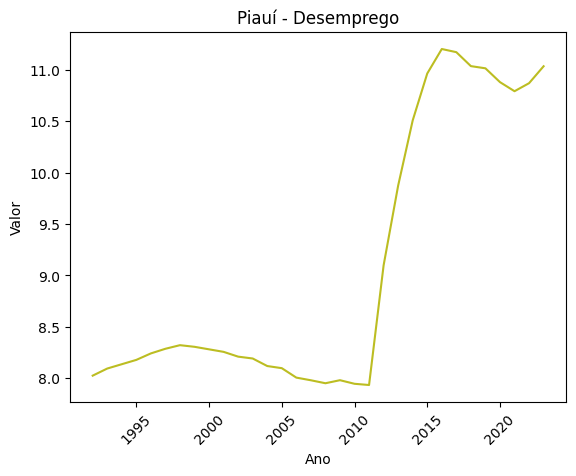

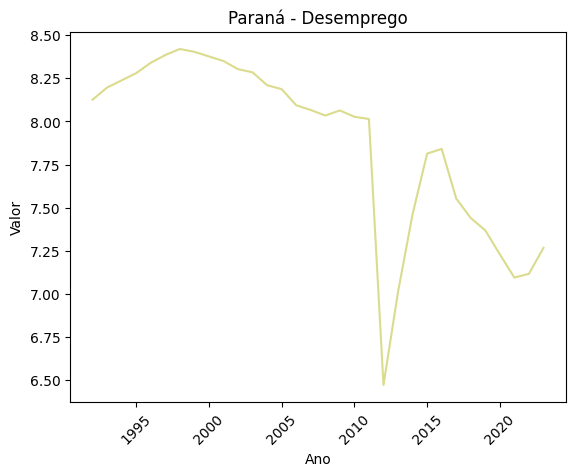

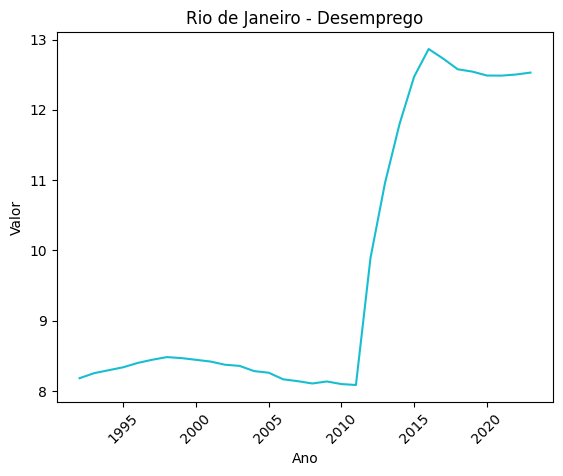

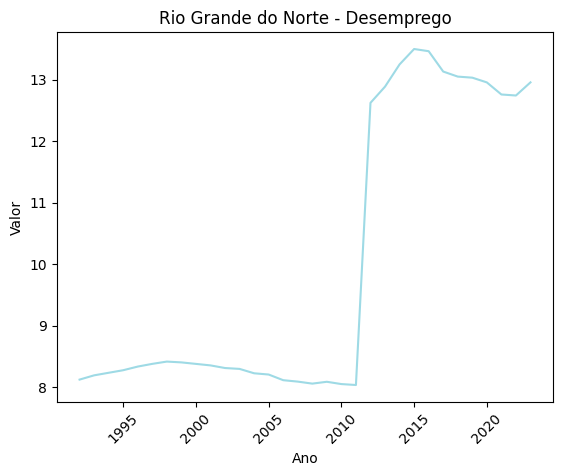

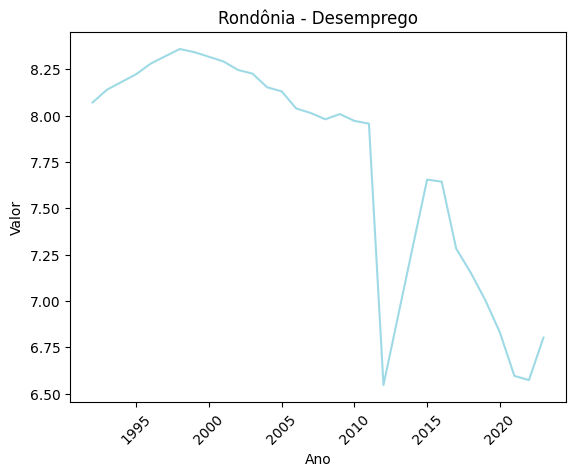

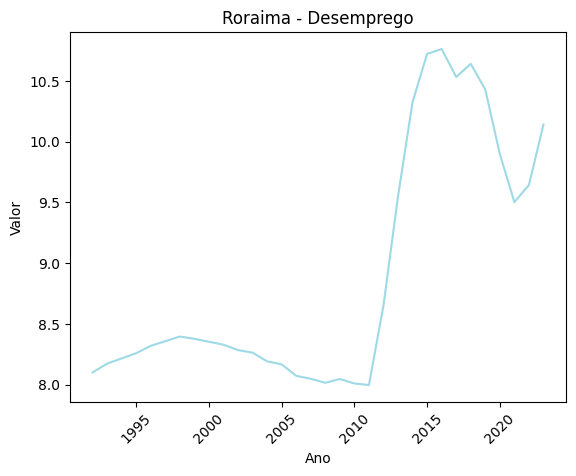

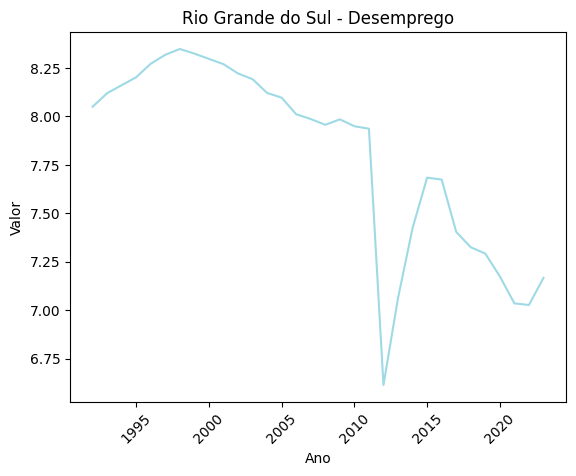

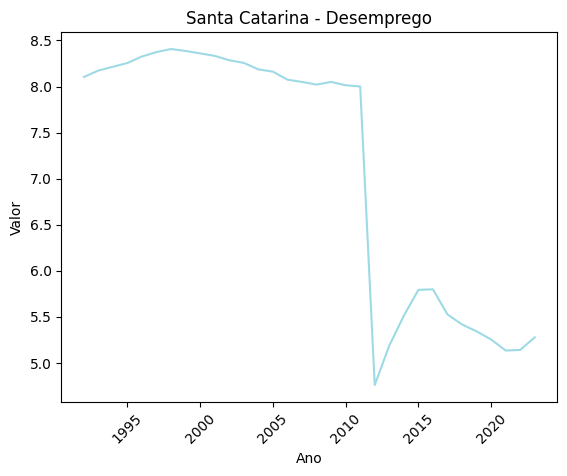

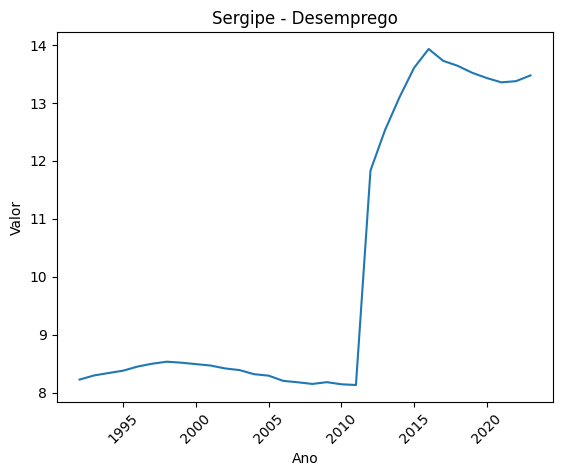

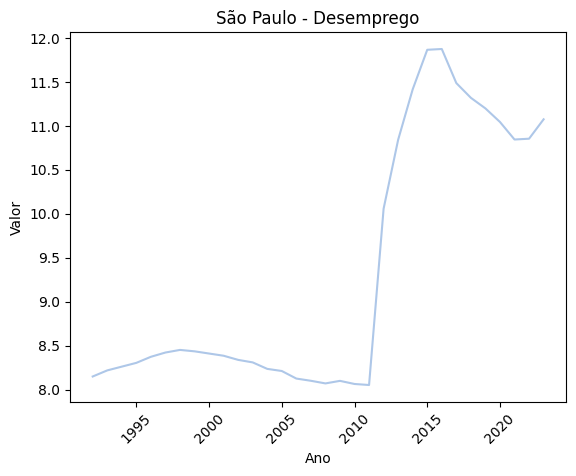

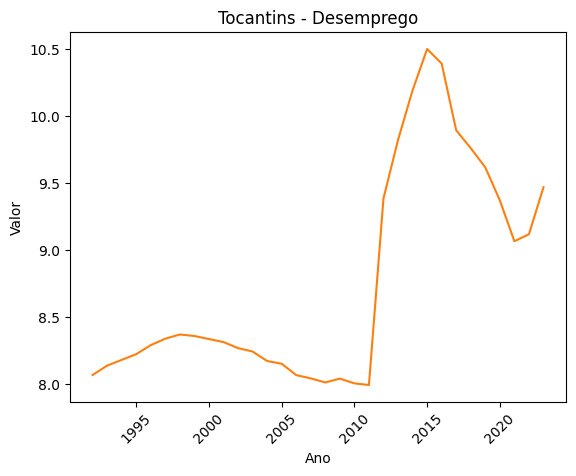

In [47]:
plot_columns(df_appended)

In [48]:
df_appended.index = df_appended.index.astype(int)
df_2014 = df_appended[df_appended.index >= 2014]
df_2014 = df_2014[df_2014.index < 2023]
df_2014

,Acre - Desemprego,Alagoas - Desemprego,Amazonas - Desemprego,Amapá - Desemprego,Bahia - Desemprego,Ceará - Desemprego,Distrito Federal - Desemprego,Espírito Santo - Desemprego,Goiás - Desemprego,Maranhão - Desemprego,...,Paraná - Desemprego,Rio de Janeiro - Desemprego,Rio Grande do Norte - Desemprego,Rondônia - Desemprego,Roraima - Desemprego,Rio Grande do Sul - Desemprego,Santa Catarina - Desemprego,Sergipe - Desemprego,São Paulo - Desemprego,Tocantins - Desemprego
Ano,,,,,,,,,,,,,,,,,,,,,
2014,11.666939,14.169213,12.610217,15.577783,15.102184,10.652422,11.799788,10.450155,9.015756,11.986521,...,7.462443,11.800434,13.251300,7.287260,10.328300,7.423718,5.511795,13.099831,11.415800,10.192991
2015,12.139670,14.659464,13.139356,16.255907,15.644545,11.020421,12.093705,10.942052,9.398111,12.529442,...,7.813261,12.471375,13.501882,7.654493,10.723767,7.683986,5.792915,13.605605,11.865646,10.501090
2016,12.458072,14.776623,13.263561,16.439693,15.852241,11.073199,12.238790,10.979229,9.378450,12.762358,...,7.840669,12.865739,13.466118,7.643673,10.764101,7.674279,5.798844,13.929548,11.874466,10.392740
2017,12.245790,14.347557,12.821072,16.090418,15.631769,10.712887,12.085632,10.448735,8.980786,12.460135,...,7.553100,12.728617,13.134883,7.282097,10.533542,7.404242,5.526597,13.725374,11.486716,9.894472
2018,12.148886,14.104975,12.662274,15.812868,15.590819,10.581166,12.018938,10.241458,8.919908,12.318837,...,7.440077,12.577126,13.052784,7.152179,10.642202,7.324869,5.417481,13.638962,11.319293,9.761228
2019,12.045733,13.904156,12.576164,15.509234,15.575601,10.594941,12.023662,10.168769,8.947167,12.204421,...,7.368470,12.544345,13.035247,7.004255,10.430272,7.291978,5.342752,13.518614,11.198876,9.617662
2020,11.905311,13.726047,12.440277,15.329624,15.515507,10.540017,11.936222,10.043678,8.745410,12.039300,...,7.229325,12.488461,12.958312,6.830604,9.898626,7.174483,5.254689,13.428525,11.044481,9.371493
2021,11.817334,13.450561,12.255143,15.114537,15.439822,10.393445,11.866376,9.839045,8.543845,11.842073,...,7.094891,12.486894,12.761460,6.595528,9.503368,7.034975,5.134381,13.354176,10.845149,9.066728
2022,11.830301,13.470373,12.276323,15.201106,15.416984,10.367164,11.896987,9.820791,8.559723,11.856801,...,7.116836,12.502730,12.744960,6.573031,9.643865,7.026740,5.141006,13.374761,10.854380,9.118915


In [49]:
df_appended.index = df_appended.index.astype(int)
df_2008 = df_appended[df_appended.index >= 2008]
df_2008 = df_2008[df_2008.index < 2023]
df_2008

,Acre - Desemprego,Alagoas - Desemprego,Amazonas - Desemprego,Amapá - Desemprego,Bahia - Desemprego,Ceará - Desemprego,Distrito Federal - Desemprego,Espírito Santo - Desemprego,Goiás - Desemprego,Maranhão - Desemprego,...,Paraná - Desemprego,Rio de Janeiro - Desemprego,Rio Grande do Norte - Desemprego,Rondônia - Desemprego,Roraima - Desemprego,Rio Grande do Sul - Desemprego,Santa Catarina - Desemprego,Sergipe - Desemprego,São Paulo - Desemprego,Tocantins - Desemprego
Ano,,,,,,,,,,,,,,,,,,,,,
2008,8.514659,8.543035,8.396886,8.281094,8.102744,8.024047,8.042711,7.934578,7.941146,7.978325,...,8.033948,8.106163,8.054622,7.979888,8.015090,7.956795,8.020915,8.151229,8.071263,8.013079
2009,8.542386,8.571316,8.420659,8.302950,8.129293,8.052145,8.070885,7.964300,7.969157,8.007891,...,8.063370,8.134661,8.084471,8.008176,8.046321,7.985037,8.049936,8.181780,8.100327,8.041614
2010,8.514295,8.539868,8.389077,8.270873,8.095385,8.017491,8.035310,7.927576,7.932921,7.971707,...,8.026843,8.098147,8.047148,7.971248,8.009229,7.949439,8.013741,8.145498,8.064867,8.006059
2011,8.500790,8.526852,8.376520,8.258737,8.084857,8.006912,8.024653,7.917310,7.921619,7.961524,...,8.013806,8.084479,8.031985,7.956614,7.996819,7.936698,8.000656,8.132819,8.053175,7.993875
2012,10.334544,12.945391,11.321769,14.118134,13.555307,9.818854,10.763245,9.395868,7.786290,10.302202,...,6.472496,9.891336,12.625418,6.546489,8.651837,6.613682,4.760238,11.832646,10.058484,9.385999
2013,11.122668,13.577910,12.008921,14.922159,14.373236,10.221864,11.341796,9.956265,8.389968,11.189661,...,7.011799,10.961499,12.889274,6.917221,9.551098,7.062492,5.187787,12.530554,10.842573,9.822894
2014,11.666939,14.169213,12.610217,15.577783,15.102184,10.652422,11.799788,10.450155,9.015756,11.986521,...,7.462443,11.800434,13.251300,7.287260,10.328300,7.423718,5.511795,13.099831,11.415800,10.192991
2015,12.139670,14.659464,13.139356,16.255907,15.644545,11.020421,12.093705,10.942052,9.398111,12.529442,...,7.813261,12.471375,13.501882,7.654493,10.723767,7.683986,5.792915,13.605605,11.865646,10.501090
2016,12.458072,14.776623,13.263561,16.439693,15.852241,11.073199,12.238790,10.979229,9.378450,12.762358,...,7.840669,12.865739,13.466118,7.643673,10.764101,7.674279,5.798844,13.929548,11.874466,10.392740


In [50]:
for column in df_2008.columns:
    file_name = f"2008_01_{column}.csv"
    column_df = df_2008[[column]]
    column_df.to_csv(file_name, index=True)